In [1]:
%matplotlib notebook
#import matplotlib.pyplot as plt
#import numpy as np
import urllib.request
import gzip
import os

def load_covtype_dataset():
    '''Downloads the Cover Type dataset from UCI repository, returning a file handle'''
    CURRENT_DIR = os.getcwd()
    COVTYPE_FILENAME = 'covtype.data'
    COVTYPE_DATA_PATH = os.path.join(CURRENT_DIR, COVTYPE_FILENAME)
    COVTYPE_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz'
    if os.path.isfile(COVTYPE_DATA_PATH):
        print('Using local cached copy in', COVTYPE_DATA_PATH)
    else:
        print('Dataset not found locally. Downloading in', COVTYPE_DATA_PATH)
        with urllib.request.urlopen(COVTYPE_URL) as response:
            with gzip.GzipFile(fileobj=response) as uncompressed, open(COVTYPE_DATA_PATH, 'wb') as out_file:
                file_header = uncompressed.read()
                out_file.write(file_header)
    return COVTYPE_DATA_PATH


In [2]:
covtype_file = load_covtype_dataset()

Using local cached copy in /notebooks/CovertypeMine/covtype.data


In [3]:
import pandas as pd
import numpy as np

df_covtype = pd.read_csv(covtype_file, header=None)

In [4]:
df_covtype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
0     581012 non-null int64
1     581012 non-null int64
2     581012 non-null int64
3     581012 non-null int64
4     581012 non-null int64
5     581012 non-null int64
6     581012 non-null int64
7     581012 non-null int64
8     581012 non-null int64
9     581012 non-null int64
10    581012 non-null int64
11    581012 non-null int64
12    581012 non-null int64
13    581012 non-null int64
14    581012 non-null int64
15    581012 non-null int64
16    581012 non-null int64
17    581012 non-null int64
18    581012 non-null int64
19    581012 non-null int64
20    581012 non-null int64
21    581012 non-null int64
22    581012 non-null int64
23    581012 non-null int64
24    581012 non-null int64
25    581012 non-null int64
26    581012 non-null int64
27    581012 non-null int64
28    581012 non-null int64
29    581012 non-null int64
30    581012 non-null int64
31    581012 non-null

In [5]:
def features_renaming(df_covtype):
    '''Rename each column to meaningful labels'''
    # First step: rename the first 14 columns
    first_fourteen_old_feature_names = df_covtype.columns[np.arange(0,14)]
    first_fourteen_new_feature_names = ['Elevation', 'Aspect', 'Slope',
                                        'Horizontal_Distance_To_Hydrology',
                                        'Vertical_Distance_To_Hydrology',
                                        'Horizontal_Distance_To_Roadways',
                                        'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                                        'Horizontal_Distance_To_Fire_Points',
                                        'Wilderness_Area_1', 'Wilderness_Area_2',
                                        'Wilderness_Area_3', 'Wilderness_Area_4']
    old_to_new_name_mapping = dict(zip(first_fourteen_old_feature_names, first_fourteen_new_feature_names))
    df_covtype.rename(columns=old_to_new_name_mapping, inplace=True)
    # Second step: rename the 40 soil type columns
    soil_type_old_feature_names = df_covtype.columns[np.arange(14,54)]
    soil_type_new_feature_names = ['Soil_Type_' + str(i) for i in np.arange(1,len(soil_type_old_feature_names)+1)]
    old_to_new_name_mapping = dict(zip(soil_type_old_feature_names, soil_type_new_feature_names))
    df_covtype.rename(columns=old_to_new_name_mapping, inplace=True)
    # Last step: rename the last feature (cover type)
    df_covtype.rename(columns={54: 'Cover_Type'}, inplace=True)
    return df_covtype

In [6]:
# Features names are numeric, let's rename each one of them
df_covtype = features_renaming(df_covtype)

In [7]:
df_covtype.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [8]:
# Check the number of samples for each class value
df_covtype.Cover_Type.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

In [9]:
train = df_covtype[:15120].copy()
# Leaving this code for future reference
# Perform a one hot encoding via get_dummies,
# then drop the integer target label as to leave the one hot encoded labels only
# one_hot_covtype = pd.get_dummies(train.Cover_Type, prefix='CovT')
# train.drop(columns='Cover_Type', inplace=True)
# train_ohe = train.join(one_hot_covtype)

<IPython.core.display.Javascript object>


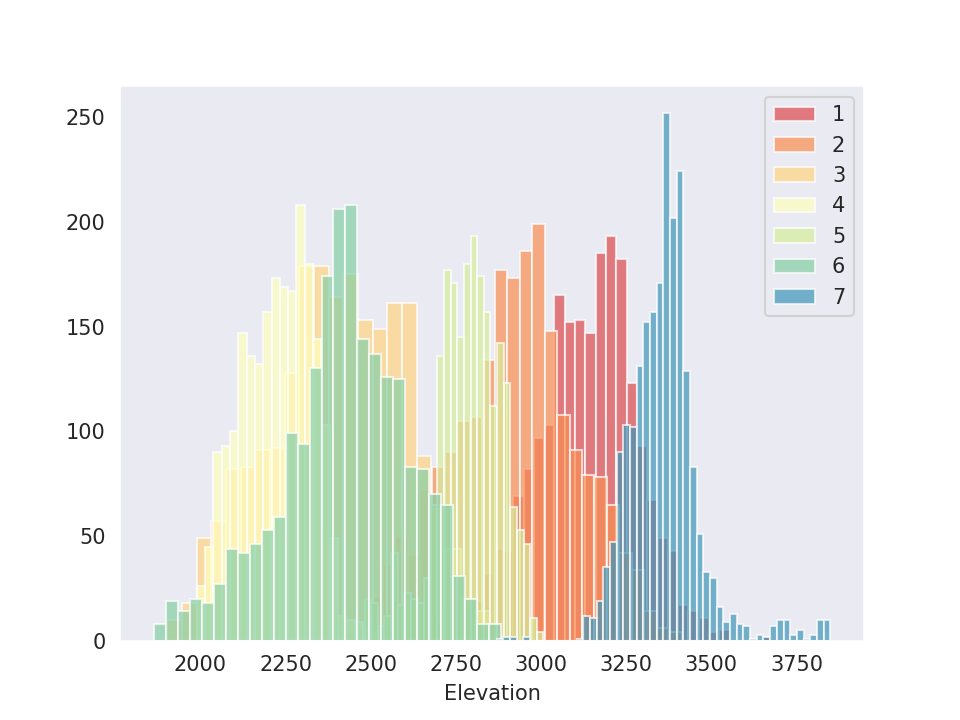

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Slice by two columns: Elevation and Cover_Type
elevations = train.loc[:, ['Elevation', 'Cover_Type']]
# Get a sorted list of Cover Types for later filtering
sorted_cover_types = sorted(elevations.Cover_Type.unique())
c = sns.color_palette('Spectral', 7)
sns.set_style('dark')
for covtype, color in zip(sorted_cover_types, c):
    by_one_covtype = elevations.groupby('Cover_Type').apply(lambda x: x[x['Cover_Type'] == covtype])
    sns.distplot(by_one_covtype.Elevation, color=color, label=covtype,
                 hist_kws=dict(alpha=0.7), kde=False)

plt.legend()
plt.show()

# Create a group for each Cover_Type and return a df satisfying the condition
# by_one_covtype = elevations.groupby('Cover_Type').apply(lambda x: x[x['Cover_Type'] == 2])

In [12]:
# ho aggiunto 7 colonne one-hot encoded al dataset e rimosso la Cover_Type di partenza
# Vorrei plottare, per ogni colonna di cover_type, la corrispettiva Elevation
#import matplotlib.pyplot as plt
#import seaborn as sns

#def filter_elevation_by_one_covtype(train_ohe, desired_covtype):
#    '''Filter the one hot encoded training set (with the target label)
#       by the desired cover type, returning a numpy array containing the
#       elevation values for that cover type
#   '''
#    d_elevation = train_ohe.loc[:, ['Elevation', desired_covtype]]
#    d_elevation = d_elevation.loc[d_elevation[desired_covtype] == 1]
#    d_elevation.drop(columns=desired_covtype, inplace=True)
#    return d_elevation.values

#covtype_labels = ['CovT_1', 'CovT_2', 'CovT_3',
#                  'CovT_4', 'CovT_5', 'CovT_6', 'CovT_7']
#filtered_elevations = []
#for idx, label in enumerate(covtype_labels):
#    filtered_elevations.append(filter_elevation_by_one_covtype(train_ohe, label))
    
# TODO capire come stackare più histograms in un 
#fig, ax = plt.subplots()
#for a in filtered_elevations:
#    sns.distplot(a, bins=range(1, 110, 10), ax=ax, kde=False)

In [13]:
# Let's split the dataset onto training set and test set according to UCI's repository guidelines
def train_test_split_covtype(df_covtype):
    '''Split the dataset onto training set and test set according to UCI's repository guidelines'''
    # First 15120 rows are for the training set
    X_train = df_covtype[:15120].copy()
    # The last column is the target label
    X_train, y_train = X_train.iloc[:, :54], X_train.iloc[:, 54]
    # The remaining rows are for the test set
    X_test = df_covtype[15121:].copy()
    X_test, y_test = X_test.iloc[:, :54], X_test.iloc[:, 54]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_covtype(df_covtype)

In [14]:
# Let's standardize the training set and test set.
# Note that we fit the training set only and then transform the test set
# (basically we don't fit AND transform the test set too)
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_std = ss.fit_transform(X_train.astype('float64'))
X_test_std = ss.transform(X_test.astype('float64'))

In [15]:
# One-hot encoding for the target label
#from sklearn.preprocessing import OneHotEncoder

#enc = OneHotEncoder(categories='auto')
#y_train_oh = enc.fit_transform(y_train.values.reshape(-1,1))

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=0.1, random_state=1, solver='liblinear', multi_class='ovr')
lr.fit(X_train_std, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=1, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
print('Logistic Regression, training accuracy: %.2f%%' % (100 * lr.score(X_train_std, y_train)))

Logistic Regression, training accuracy: 67.28%


# Let's try some feature selection. Most of the features are encoded from categorical data,
# thus Chi Squared test can help us identify dependent/independent features.
# For continuous features, a correlation matrix would have been appropriate
# Note that Chi Squared test works on non-negative values only
features_to_test = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                    'Wilderness_Area_1', 'Wilderness_Area_2',
                    'Wilderness_Area_3', 'Wilderness_Area_4']
all_soil_types = ['Soil_Type_' + str(i) for i in np.arange(1,41)]
# 47 features will be used for Chi Squared testing
features_to_test = features_to_test + all_soil_types

from sklearn.feature_selection import SelectKBest, chi2

# k=10 to get the first 10 best features from Chi Squared test
chi2_selector = SelectKBest(chi2, k=10)
chi2_selector.fit(X_train[features_to_test], y_train)

# Check the scores
chi2_selector.scores_

best_features_filter = chi2_selector.get_support()
features_to_test = np.array(features_to_test)
features_to_test[best_features_filter]